In [1]:
import itertools
itertools.permutations()

TypeError: Required argument 'iterable' (pos 1) not found

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import pickle
import sklearn.metrics as met
import xgboost as xgb

from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)

In [16]:
import pickle
with open('raw_data_20190115.pickle', 'rb') as handle:
    raw_data = pickle.load(handle)

In [17]:
for i,j in raw_data.items():
    raw_data[i] = j.loc['2006-01-01':]

In [18]:
use_stock = ['KB금융', 'LG', 'LG생활건강', 'LG화학', 'NAVER', 'SK', 'SK이노베이션', 'SK텔레콤', 'SK하이닉스', '삼성생명', '삼성전자', '삼성중공업', '셀트리온', '신한지주', '현대건설', '현대글로비스']
del_li = [i for i in raw_data.keys() if i not in use_stock]
for stock in del_li:
    del raw_data[stock]
print(len(raw_data.keys()))

16


In [19]:
len(raw_data['삼성전자'].loc['2017-06-30':'2018-08-13'])

272

In [20]:
    def get_MACD(df, short_ma=12, long_ma=26, signal_period=9):
        ewm_12 = df['Close'].ewm(span = short_ma, min_periods = short_ma - 1).mean()
        ewm_26 = df['Close'].ewm(span = long_ma, min_periods = long_ma - 1).mean()
        df['MACD'] = ewm_12 - ewm_26
        df['MACDSignal'] = df['MACD'].ewm(span = signal_period, min_periods = signal_period-1).mean()
        df['MACDDiff'] = df['MACD'] - df['MACDSignal']
        return df

    def get_Stochastic(df, n=14):
        df['sto_K_{}'.format(n)] = 100 * ((df.Close - df.Low.rolling(n).min()) / 
                                          (df.High.rolling(n).max() - df.Low.rolling(n).min()))
        df['sto_D_{}'.format(n)] = df['sto_K_{}'.format(n)].rolling(3).mean()
        return df

    def get_RSI(df, n=14):
        U = np.where(df['Close'].diff(1)>0, df['Close'].diff(1), 0)
        D = np.where(df['Close'].diff(1)<0, df['Close'].diff(1)*(-1), 0)

        AU = pd.Series(U).rolling(window=n, min_periods=n).mean()
        AD = pd.Series(D).rolling(window=n, min_periods=n).mean()

        RSI = AU.div(AD+AU) * 100
        df['RSI_{}'.format(n)] = RSI.values
        return df

    def get_BolingerBand(df, n=20, k=2):
        df = df.assign(BolingerCenter = df['Close'].rolling(window=n).mean())
        df = df.assign(Bol_upper = df['Close'].rolling(window=n).mean() + k*df['Close'].rolling(window=n).std())
        df = df.assign(Bol_lower = df['Close'].rolling(window=n).mean() - k*df['Close'].rolling(window=n).std())
        return df

    def get_SMA(df, window):
        df['close_ma_{}'.format(window)] = df['Close'].rolling(window).mean()
        return df

    def get_EMA(df, window):
        df['close_ema_{}'.format(window)] = df['Close'].ewm(span=window).mean()
        return df

    def get_RoC(df, periods):
        df['roc_{}'.format(periods)] = df['Close'].pct_change(periods=periods)
        return df

    def get_CV(df, window):
        df['his_vol_{}'.format(window)] = np.log(df['Close'] / df['Close'].shift(1)).rolling(window).std()*(252**0.5)
        return df

    def get_WilliamR(df, n):
        W_R = -100 * ((df.High.rolling(n).max() - df.Close) / (df.High.rolling(n).max() - df.Low.rolling(n).min()))
        df['WR_{}'.format(n)] = W_R
        return df

    def get_CCI(df, window):
        TP = (df.Close + df.Low + df.High) / 3
        dataX = []
        for i in range(len(TP) - window+1):
            a = TP.values[i:(i+window)]
            dataX.append(a)
        dataMean = [i.mean() for i in dataX]
        AVEDEV = [abs(x - mean).mean() for x, mean 
                  in zip(dataX, dataMean)]
        for i in range(window-1):
            AVEDEV.insert(0,np.nan)
        AVEDEV = pd.Series(AVEDEV, index = TP.index)
        CCI = (TP - TP.rolling(20).mean()) / (0.015 * AVEDEV)
        df['CCI_{}'.format(window)] = CCI
        return df

    def get_DI(df, window):
        df['DI_{}'.format(window)] = 100 * ((df.Close - df.Close.rolling(window).mean()) / df.Close.rolling(window).mean())
        return df

    def get_VPT(df):
        df['VPT'] = ((test.Close.diff(1) / test.Close) * test.Volume).cumsum()
        return df

    def get_MA_diff(df, window):
        df['ma_diff_{}'.format(window)] = df['Close'].rolling(window).mean() - df['Close'].shift(window).rolling(window).mean()
        return df

    def get_MA_n_diff(df, n, window):
        df['ma_{}_diff_{}'.format(n, window)] = df['Close'].rolling(window).mean() - df['Close'].rolling(window+n).mean()
        return df

    def get_OBV(df):
        df['OBV'] = (np.sign(df['Close'].diff(1).fillna(0)) * df['Volume']).cumsum()
        return df

In [21]:
import time
for key, df in raw_data.items():
    start = time.time()
    for window in range(1, 91):
        raw_data[key] = get_SMA(df, window)
        raw_data[key] = get_EMA(df, window)
    n = 10
    for window in range(1, 91):
        raw_data[key] = get_MA_diff(df, window)
        raw_data[key] = get_MA_n_diff(df, n, window)
    for window in range(12, 91):
        raw_data[key] = get_CV(df, window)
    for periods in range(1, 11):
        raw_data[key] = get_RoC(df, periods)
    for n in range(3, 91):
        raw_data[key] = get_RSI(df, n)
        raw_data[key] = get_Stochastic(df, n)
        raw_data[key] = get_WilliamR(df, n)
    raw_data[key] = get_CCI(df, 20)
    for window in [5,10]:
        raw_data[key] = get_DI(df, window)
    raw_data[key] = get_MACD(df)
    raw_data[key] = get_OBV(df)
    print(key, ': {:.2f} sec'.format(time.time() - start))

KB금융 : 2.44 sec
LG : 2.09 sec
LG생활건강 : 2.13 sec
LG화학 : 2.29 sec
NAVER : 2.64 sec
SK : 2.09 sec
SK이노베이션 : 2.18 sec
SK텔레콤 : 2.13 sec
SK하이닉스 : 2.12 sec
삼성생명 : 1.97 sec
삼성전자 : 1.99 sec
삼성중공업 : 1.98 sec
셀트리온 : 2.01 sec
신한지주 : 1.98 sec
현대건설 : 2.01 sec
현대글로비스 : 2.02 sec


In [22]:
len(raw_data['삼성전자'].loc['2017-06-30':'2018-08-13'])

272

In [23]:
for key, df in raw_data.items():
    print(key)
    for i in range(1, 33, 3):
        df['Y1_{:02}'.format(i)] = np.log(df['Close'].shift(-1*i) / df['Close'])
        for j in range(1, 90, 3):
            df['sh{:02}_Y2_{:02}'.format(i, j)] = np.log(df['Close'].shift(-1*i) / df['Close'].rolling(j).mean())

KB금융
LG
LG생활건강
LG화학
NAVER
SK
SK이노베이션
SK텔레콤
SK하이닉스
삼성생명
삼성전자
삼성중공업
셀트리온
신한지주
현대건설
현대글로비스


In [24]:
y_li = [i
    for i in [col for col in raw_data['삼성전자'] 
              if (col.find('Y') != -1)]
]
print(len(y_li))

341


In [25]:
len(raw_data['삼성전자'].loc['2017-06-30':'2018-08-13'])

272

In [12]:
prepare_training = {}
for key, df in raw_data.items():
    start = time.time()
    target_set = {}
    for y in y_li:
        col_set = {}
        for col_name in ['sto_K','sto_D','RSI','close_ma','close_ema','roc','his_vol','WR',
                         'CCI','DI','ma_diff','MACD','MACDSignal','MACDDiff','OBV']:
            corr_ = abs(df[[col for col in df if (col.find(col_name) != -1)|
                    (col.find(y) != -1)]].corr()[y]).sort_values(ascending=False)
            col_set[corr_.index[1]] = corr_.iloc[1]
        target_set[y] = col_set
    prepare_training[key] = target_set
    elapse = time.time() - start
    print(key, ': {:.2f} sec'.format(elapse))

KeyboardInterrupt: 

In [ ]:
prepare_training

In [13]:
with open('raw_and_prepare_columns_20190416.pickle', 'rb') as handle:
    raw_data, prepare_training = pickle.load(handle)

In [26]:
len(raw_data['삼성전자'].loc['2017-06-30':'2018-08-13'])

272

In [27]:
raw_data['삼성생명']

,Open,High,Low,Close,Adj Close,Volume,close_ma_1,close_ema_1,close_ma_2,close_ema_2,...,sh31_Y2_61,sh31_Y2_64,sh31_Y2_67,sh31_Y2_70,sh31_Y2_73,sh31_Y2_76,sh31_Y2_79,sh31_Y2_82,sh31_Y2_85,sh31_Y2_88
Date,,,,,,,,,,,,,,,,,,,,,
2010-05-12,119500.0,121000.0,112500.0,114000.0,100982.273438,9504811,114000.0,114000.0,NaN,114000.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-05-13,115500.0,117000.0,115000.0,115500.0,102310.992188,2184611,115500.0,115500.0,114750.0,115125.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-05-14,115000.0,116500.0,112000.0,114000.0,100982.273438,1766046,114000.0,114000.0,114750.0,114346.153846,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-05-17,112000.0,113500.0,107500.0,107500.0,95224.523438,2436796,107500.0,107500.0,110750.0,109725.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-05-18,108500.0,110000.0,107000.0,110000.0,97439.046875,992698,110000.0,110000.0,108750.0,109909.090909,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-05-19,109000.0,110000.0,107500.0,109500.0,96996.140625,849604,109500.0,109500.0,109750.0,109635.989011,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-05-20,109500.0,111000.0,107500.0,107500.0,95224.523438,737460,107500.0,107500.0,108500.0,108211.344922,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-05-24,105000.0,106000.0,101500.0,102500.0,90795.476563,1211758,102500.0,102500.0,105000.0,104403.201220,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-05-25,100500.0,101000.0,95500.0,98000.0,86809.328125,1594192,98000.0,98000.0,100250.0,100134.183518,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
prepare_training['삼성전자']

{'Y1_01': {'sto_K_11': 0.058537393897718545,
  'sto_D_3': 0.09869205158697371,
  'RSI_4': 0.07125182991661284,
  'close_ma_2': 0.011743972804055364,
  'close_ema_1': 0.011242944059941699,
  'roc_4': 0.09389231702072381,
  'his_vol_76': 0.02300552049180816,
  'WR_11': 0.05853739389771856,
  'CCI_20': 0.04746262068244493,
  'DI_10': 0.08500071826206886,
  'ma_diff_3': 0.09116719492400285,
  'MACDDiff': 0.06967870171311803,
  'MACDSignal': 0.008151346407207206,
  'OBV': 0.024610326818881513},
 'sh01_Y2_01': {'sto_K_11': 0.058537393897718545,
  'sto_D_3': 0.09869205158697371,
  'RSI_4': 0.07125182991661284,
  'close_ma_2': 0.011743972804055364,
  'close_ema_1': 0.011242944059941699,
  'roc_4': 0.09389231702072381,
  'his_vol_76': 0.02300552049180816,
  'WR_11': 0.05853739389771856,
  'CCI_20': 0.04746262068244493,
  'DI_10': 0.08500071826206886,
  'ma_diff_3': 0.09116719492400285,
  'MACDDiff': 0.06967870171311803,
  'MACDSignal': 0.008151346407207206,
  'OBV': 0.024610326818881513},
 'sh0

store = (raw_data, prepare_training)
with open('raw_and_prepare_columns_20190416.pickle', 'wb') as handle:
    pickle.dump(store, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [46]:
raw_data['삼성전자'].loc['2018-04-27':'2018-05-10'] = raw_data['삼성전자'].loc['2018-04-27':'2018-05-10'].fillna(0)
raw_data['삼성전자'].loc['2018-04-27':'2018-05-10'][['Close','High','Low','RSI_3','sto_K_3','sto_D_3','WR_3']]

,Close,High,Low,RSI_3,sto_K_3,sto_D_3,WR_3
Date,,,,,,,
2018-04-27,53000.0,53640.0,52440.0,97.744361,85.520362,75.366277,-14.479638
2018-04-30,53000.0,53000.0,53000.0,100.000000,80.246914,88.362334,-19.753086
2018-05-02,53000.0,53000.0,53000.0,100.000000,46.666667,70.811314,-53.333333
2018-05-03,53000.0,53000.0,53000.0,0.000000,0.000000,0.000000,0.000000
2018-05-04,51900.0,53900.0,51800.0,0.000000,4.761905,0.000000,-95.238095
2018-05-08,52600.0,53200.0,51900.0,38.888889,38.095238,0.000000,-61.904762
2018-05-09,50900.0,52800.0,50900.0,20.000000,0.000000,14.285714,-100.000000
2018-05-10,51600.0,51700.0,50600.0,45.161290,38.461538,25.518926,-61.538462


In [49]:
for i,j in raw_data.items():
    raw_data[i] = j.dropna().loc['2007-01-01':]

In [186]:
Train, Test = {}, {}
for i, df in raw_data.items():
    d1, d2 = {}, {}
    for y in y_li:
        li = list(prepare_training[i][y].keys())
        li.append(y)
        d1[y] = df[li].loc[:'2017-06-29']
        d2[y] = df[li].loc['2017-06-30':]
    Train[i] = d1
    Test[i] = d2

In [187]:
Y1col = [col for col in raw_data['삼성전자'].columns if col.find('Y1') != -1]
Y1_set = {}
for i,j in raw_data.items():
    Y1_set[i] = j[Y1col]

with open('Y1_set_20190416.pickle', 'wb') as handle:
    pickle.dump(Y1_set, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [188]:
Y1_train, Y1_test = {}, {}
for i,j in Y1_set.items():
    Y1_train[i] = j.loc[:'2017-06-29']
    Y1_test[i] = j.loc['2017-06-30':]

In [189]:
def optimize_n_estimators(alg, X_train, y_train,
                 cv_folds=5, early_stopping_rounds=50):
    xgb_param = alg.get_xgb_params()
    xgtrain = xgb.DMatrix(X_train, label=y_train)
    cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
        metrics='rmse', early_stopping_rounds=early_stopping_rounds, show_stdv=False)
    alg.set_params(n_estimators=cvresult.shape[0])
    return alg

In [58]:
stock_score = {}
for stock, d_dict in Train.items():
    start = time.time()
    res = {}
    for y, df in d_dict.items():
        if len(y) > 6:
            comp_y = 'Y1_{}'.format(y[2:4])
        else:
            comp_y = y
        X_li = [i for i in df.columns if y != i]
        X_train = df.iloc[:int(.7*len(df))][X_li]
        y_train = df.iloc[:int(.7*len(df))][y]
        X_test = df.iloc[int(.7*len(df)):][X_li]
#         Y_test = df.iloc[int(.7*len(df)):][y]
        Y_test = Y1_train[stock].iloc[int(.7*len(df)):][comp_y]
        
        xgb_reg = xgb.XGBRegressor(
             learning_rate =0.15,
             n_estimators=100,
             max_depth=5,
             min_child_weight=2,
             gamma=0,
             subsample=0.8,
             colsample_bytree=0.8,
             nthread=4,
             scale_pos_weight=1,
             seed=27,
             eval_metric='map')
#         xgb_reg = optimize_n_estimators(alg, X_train, y_train,
#                            cv_folds=2, early_stopping_rounds=10)
        xgb_reg.fit(X_train, y_train)
        # 여기에 최적화 작업 들어가도 괜찮
        
        y_true = np.where(Y_test>0, 1, 0)
        y_pred = np.where(xgb_reg.predict(X_test)>0, 1, 0)
        
        measure = [
            met.accuracy_score(y_true, y_pred),
            met.precision_score(y_true, y_pred),
            met.recall_score(y_true, y_pred),
            met.f1_score(y_true, y_pred),
            met.roc_auc_score(y_true, y_pred)
        ]
        res[y] = measure
    elapse = time.time() - start
    print(stock, ': {:.2f} sec'.format(elapse))
    T = pd.DataFrame(res).T
    T.columns = ['accuracy',
                'precision',
                'recall',
                'auc',
                'f1_score']
    stock_score[stock] = T

KB금융 : 78.66 sec
LG : 84.26 sec
LG생활건강 : 83.67 sec
LG화학 : 89.34 sec
NAVER : 86.44 sec
SK : 72.09 sec
SK이노베이션 : 79.07 sec
SK텔레콤 : 86.05 sec
SK하이닉스 : 86.52 sec
삼성생명 : 68.37 sec
삼성전자 : 82.43 sec
삼성중공업 : 91.31 sec
셀트리온 : 85.87 sec
신한지주 : 84.14 sec
현대건설 : 87.87 sec
현대글로비스 : 85.27 sec


In [59]:
max_precision, max_precision_day = {}, {}
for stock in stock_score.keys():
    df = stock_score[stock].iloc[11:]
    df['g_index'] = np.concatenate([i * np.ones(30) for i in range(1,32,3)])
    df = df.groupby('g_index').mean()
    max_precision_day[stock] = df['precision'].idxmax()
    max_precision[stock] = df['precision'].max()

C:\Users\JinMyungHun\Anaconda3\envs\ds\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [60]:
max_precision

{'KB금융': 0.6827190820465735,
 'LG': 0.6922097603726247,
 'LG생활건강': 0.5896611136392768,
 'LG화학': 0.5678386892770476,
 'NAVER': 0.5720864435849002,
 'SK': 0.5195765446010578,
 'SK이노베이션': 0.5958257423621813,
 'SK텔레콤': 0.7051437949453978,
 'SK하이닉스': 0.644423470496933,
 '삼성생명': 0.5374958457680381,
 '삼성전자': 0.6624575815573258,
 '삼성중공업': 0.4703763341958403,
 '셀트리온': 0.5292810911062191,
 '신한지주': 0.48697466430910896,
 '현대건설': 0.5134452793477855,
 '현대글로비스': 0.47692733289338446}

In [61]:
max_precision_day

{'KB금융': 31.0,
 'LG': 28.0,
 'LG생활건강': 22.0,
 'LG화학': 28.0,
 'NAVER': 16.0,
 'SK': 19.0,
 'SK이노베이션': 31.0,
 'SK텔레콤': 28.0,
 'SK하이닉스': 19.0,
 '삼성생명': 7.0,
 '삼성전자': 28.0,
 '삼성중공업': 16.0,
 '셀트리온': 31.0,
 '신한지주': 22.0,
 '현대건설': 25.0,
 '현대글로비스': 7.0}

In [104]:
stock = 'KB금융'
('0{}'.format(int(max_precision_day[stock])) if int(max_precision_day[stock])<10 else str(int(max_precision_day[stock])))

'31'

In [235]:
new_Train = {}
for stock, d_dict in Train.items():
    new_dict = {}
    for y, df in d_dict.items():
        if y.find('Y1') != -1:
            continue
        elif y[2:4] == '01':
            new_dict[y] = df
        elif y[2:4] == ('0{}'.format(int(max_precision_day[stock])) if int(max_precision_day[stock])<10 else str(int(max_precision_day[stock]))):
            new_dict[y] = df
    new_Train[stock] = new_dict

new_Test = {}
for stock, d_dict in Test.items():
    new_dict = {}
    for y, df in d_dict.items():
        if y.find('Y1') != -1:
            continue
        elif y[2:4] == '01':
            new_dict[y] = df
        elif y[2:4] == ('0{}'.format(int(max_precision_day[stock])) if int(max_precision_day[stock])<10 else str(int(max_precision_day[stock]))):
            new_dict[y] = df
    new_Test[stock] = new_dict

In [63]:
import sys
mod = sys.modules[__name__]

In [64]:
import warnings
warnings.filterwarnings("ignore")

In [65]:
max_precision_day['삼성생명']

7.0

In [182]:
for i,j in raw_data.items():
    print(len(j), j.index[0], j.index[-1], i)

2277 2009-06-02 00:00:00 2018-08-13 00:00:00 KB금융
2882 2007-01-02 00:00:00 2018-08-13 00:00:00 LG
2872 2007-01-02 00:00:00 2018-08-13 00:00:00 LG생활건강
2868 2007-01-02 00:00:00 2018-08-13 00:00:00 LG화학
2853 2007-01-02 00:00:00 2018-08-13 00:00:00 NAVER
1982 2010-07-30 00:00:00 2018-08-13 00:00:00 SK
2553 2008-04-18 00:00:00 2018-08-13 00:00:00 SK이노베이션
2881 2007-01-02 00:00:00 2018-08-13 00:00:00 SK텔레콤
2882 2007-01-02 00:00:00 2018-08-13 00:00:00 SK하이닉스
1854 2011-01-26 00:00:00 2018-08-13 00:00:00 삼성생명
2883 2007-01-02 00:00:00 2018-08-13 00:00:00 삼성전자
2882 2007-01-02 00:00:00 2018-08-13 00:00:00 삼성중공업
2854 2007-01-02 00:00:00 2018-08-13 00:00:00 셀트리온
2883 2007-01-02 00:00:00 2018-08-13 00:00:00 신한지주
2882 2007-01-02 00:00:00 2018-08-13 00:00:00 현대건설
2872 2007-01-02 00:00:00 2018-08-13 00:00:00 현대글로비스


In [195]:
a = pd.concat((Y1_train['삼성전자']['Y1_01'], Y1_test['삼성전자']['Y1_01']), axis=0)

In [205]:
pd.Timestamp('2017-06-30')+pd.Timedelta('1D')

Timestamp('2017-07-01 00:00:00')

In [234]:
new_Train['삼성전자']['sh01_Y2_01']

,sto_K_11,sto_D_3,RSI_4,close_ma_2,close_ema_1,roc_4,his_vol_76,WR_11,CCI_20,DI_10,ma_diff_3,MACDDiff,MACDSignal,OBV,sh01_Y2_01
Date,,,,,,,,,,,,,,,
2007-01-02,96.296296,86.786019,80.000000,12390.0,12520.0,0.024550,0.182169,-3.703704,33.901874,2.070765,120.000000,28.857905,-125.065693,-197091500.0,-0.019355
2007-01-03,46.153846,60.860093,60.606061,12400.0,12280.0,0.011532,0.182893,-53.846154,9.094873,0.032584,140.000000,26.442472,-118.455075,-216768000.0,-0.013115
2007-01-04,15.384615,43.291465,38.235294,12200.0,12120.0,-0.013029,0.184040,-84.615385,-68.557920,-1.206391,80.000000,14.411474,-114.852206,-235026900.0,-0.018319
2007-01-05,0.000000,11.407407,29.545455,12010.0,11900.0,-0.029364,0.184371,-100.000000,-139.367816,-2.777778,-253.333333,-6.877596,-116.571606,-263427300.0,-0.018660
2007-01-08,10.204082,9.050505,0.000000,11790.0,11680.0,-0.067093,0.182991,-89.795918,-274.169466,-4.057828,-453.333333,-32.837763,-124.781046,-296508850.0,0.003419
2007-01-09,14.285714,12.828283,6.250000,11700.0,11720.0,-0.045603,0.183129,-85.714286,-213.917526,-3.236460,-540.000000,-43.697371,-135.705389,-276399000.0,-0.013746
2007-01-10,5.660377,18.091441,6.250000,11640.0,11560.0,-0.046205,0.177514,-94.339623,-229.865772,-4.034534,-446.666667,-57.186901,-150.002115,-302155300.0,0.008613
2007-01-11,15.094340,27.076023,26.923077,11610.0,11660.0,-0.020168,0.178562,-84.905660,-157.105031,-2.817136,-253.333333,-54.894738,-163.725799,-272315950.0,0.038693
2007-01-12,58.490566,52.631579,78.947368,11890.0,12120.0,0.037671,0.192907,-41.509434,-41.573613,1.151728,13.333333,-19.731600,-168.658699,-231969900.0,0.009852


In [258]:
cond_result = {}
train_result = {}

for stock, d_dict in new_Train.items():
#     if stock not in  ['삼성전자','삼성생명']:
#         continue
    start = time.time()
    
#     i = int(max_precision_day[stock])
    res_1, res_max = {}, {}
    stat_1, stat_max = {}, {}
    res = {}
    for cond in [1,2]:
        for maxor in [1, 'max']:
            for percent in [.3,.4,.5,.6,.7,.8,.9]:
                setattr(mod, 'Cond{0}_{1}_{2:.0f}'.format(cond, maxor, percent*100), {})
    for y, df in d_dict.items():
        comp_y = 'Y1_{}'.format(y[2:4])

        X_li = [i for i in df.columns if y != i]
        X_train = df[X_li]
        y_train = df[y]
        X_test = new_Test[stock][y][X_li]
        Y_test = Y1_test[stock][comp_y]

        xgb_reg = xgb.XGBRegressor(
             learning_rate =0.15,
             n_estimators=100,
             max_depth=5,
             min_child_weight=2,
             gamma=0,
             subsample=0.8,
             colsample_bytree=0.8,
             nthread=4,
             scale_pos_weight=1,
             seed=27,
             eval_metric='map')
        
#         xgb_reg = optimize_n_estimators(alg, X_train, y_train,
#                    cv_folds=3, early_stopping_rounds=20)
        xgb_reg.fit(X_train, y_train)

        y_true = np.where(Y_test>0, 1, 0)
        y_pred = np.where(xgb_reg.predict(X_test)>0, 1, 0)

        measure = [
            met.accuracy_score(y_true, y_pred),
            met.precision_score(y_true, y_pred),
            met.recall_score(y_true, y_pred),
            met.f1_score(y_true, y_pred),
            met.roc_auc_score(y_true, y_pred)
        ]

        k = 0
        n = 1 if y[2:4] == '01' else int(max_precision_day[stock])
        Y1_dtrain = pd.concat((Y1_train[stock][comp_y], 
                               Y1_test[stock][comp_y]),
                             axis=0)
        X_dtrain = pd.concat((X_train, X_test), axis=0)
        
        cond1_30, cond1_40, cond1_50, cond1_60, cond1_70, cond1_80 = [], [], [], [], [], []
        cond2_50, cond2_60, cond2_70, cond2_80, cond2_90 = [], [], [], [], []
        
        sep = np.where(X_dtrain.index == pd.Timestamp('2017-06-30'))[0][0]
        
        while k < len(X_dtrain)-sep-90:
            pred_90 = xgb_reg.predict(X_dtrain.iloc[sep-90-n+k:sep-n+k])
            true_90 = Y1_dtrain.iloc[sep-90-n+k:sep-n+k]
            precision_90 = met.precision_score(
                np.where(true_90>0,1,0), 
                np.where(pred_90>0,1,0))

            for TOL in [.3,.4,.5,.6,.7,.8]:
                if precision_90 < TOL:
                    getattr(mod, 'cond1_{:.0f}'.format(int(TOL*100))).append(-1)
                else:
                    getattr(mod, 'cond1_{:.0f}'.format(int(TOL*100))).append(np.nan)

            for alpha in [.5,.6,.7,.8,.9]:
                if precision_90 < max_precision[stock] * alpha:
                    getattr(mod, 'cond2_{:.0f}'.format(int(alpha*100))).append(-1) 
                else:
                    getattr(mod, 'cond2_{:.0f}'.format(int(alpha*100))).append(np.nan)
            k += 1
        for cond in [cond1_30, cond1_40, cond1_50, cond1_60, cond1_70, cond1_80,
                cond2_50, cond2_60, cond2_70, cond2_80, cond2_90]:
            for i in range(90):
                cond.append(np.nan)

        if y[2:4] == '01':
            res_1['Pred_{}'.format(y[-2:])] = y_pred
            stat_1['Pred_{}'.format(y[-2:])] = measure
            
            Cond1_1_30['Pred_{}'.format(y[-2:])] = cond1_30
            Cond1_1_40['Pred_{}'.format(y[-2:])] = cond1_40
            Cond1_1_50['Pred_{}'.format(y[-2:])] = cond1_50
            Cond1_1_60['Pred_{}'.format(y[-2:])] = cond1_60
            Cond1_1_70['Pred_{}'.format(y[-2:])] = cond1_70
            Cond1_1_80['Pred_{}'.format(y[-2:])] = cond1_80
            Cond2_1_50['Pred_{}'.format(y[-2:])] = cond2_50
            Cond2_1_60['Pred_{}'.format(y[-2:])] = cond2_60
            Cond2_1_70['Pred_{}'.format(y[-2:])] = cond2_70
            Cond2_1_80['Pred_{}'.format(y[-2:])] = cond2_80
            Cond2_1_90['Pred_{}'.format(y[-2:])] = cond2_90
        else:
            res_max['Pred_{}'.format(y[-2:])] = y_pred
            stat_max['Pred_{}'.format(y[-2:])] = measure
            
            Cond1_max_30['Pred_{}'.format(y[-2:])] = cond1_30
            Cond1_max_40['Pred_{}'.format(y[-2:])] = cond1_40
            Cond1_max_50['Pred_{}'.format(y[-2:])] = cond1_50
            Cond1_max_60['Pred_{}'.format(y[-2:])] = cond1_60
            Cond1_max_70['Pred_{}'.format(y[-2:])] = cond1_70
            Cond1_max_80['Pred_{}'.format(y[-2:])] = cond1_80
            Cond2_max_50['Pred_{}'.format(y[-2:])] = cond2_50
            Cond2_max_60['Pred_{}'.format(y[-2:])] = cond2_60
            Cond2_max_70['Pred_{}'.format(y[-2:])] = cond2_70
            Cond2_max_80['Pred_{}'.format(y[-2:])] = cond2_80
            Cond2_max_90['Pred_{}'.format(y[-2:])] = cond2_90

    for cond in [1,2]:
        for maxor in [1, 'max']:
            for percent in [.3,.4,.5,.6,.7,.8,.9]:
                try:
                    c = getattr(mod, 'Cond{0}_{1}_{2:.0f}'.format(cond, maxor, percent*100))
                except:
                    continue
                res['Cond{0}_{1}_{2:.0f}'.format(cond, maxor, percent*100)] = pd.DataFrame(c)
    cond_result[stock] = res
    train_result[stock] = (res_1, stat_1, res_max, stat_max)
    print(stock, ': {:.2f} sec'.format(time.time() - start))

KB금융 : 39.20 sec
LG : 40.79 sec
LG생활건강 : 40.37 sec
LG화학 : 38.83 sec
NAVER : 38.58 sec
SK : 35.23 sec
SK이노베이션 : 37.21 sec
SK텔레콤 : 41.54 sec
SK하이닉스 : 45.40 sec
삼성생명 : 33.76 sec
삼성전자 : 40.11 sec
삼성중공업 : 38.38 sec
셀트리온 : 38.90 sec
신한지주 : 37.94 sec
현대건설 : 38.21 sec
현대글로비스 : 39.50 sec


In [259]:
base_result = {}
for stock, d_dict in train_result.items():
    base_result[stock] = pd.DataFrame(d_dict[2])

In [260]:
base_result['삼성생명']

,Pred_01,Pred_04,Pred_07,Pred_10,Pred_13,Pred_16,Pred_19,Pred_22,Pred_25,Pred_28,...,Pred_61,Pred_64,Pred_67,Pred_70,Pred_73,Pred_76,Pred_79,Pred_82,Pred_85,Pred_88
0,1,0,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
1,0,0,0,1,0,1,0,1,0,0,...,1,1,1,1,1,1,1,1,1,1
2,0,0,1,1,0,1,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
3,0,0,0,1,0,1,0,0,0,0,...,0,1,1,1,1,1,1,1,1,1
4,0,1,1,1,1,1,1,1,0,0,...,1,1,1,1,1,1,1,1,1,1
5,0,0,1,1,1,1,1,1,0,0,...,1,1,1,1,1,1,1,1,1,1
6,0,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
7,0,0,1,1,1,1,1,1,1,0,...,1,1,1,1,1,1,1,1,1,1
8,0,0,0,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
9,0,0,0,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [265]:
(cond_result['삼성전자']['Cond2_1_60'] == -1).sum()

Pred_01     0
Pred_04    11
Pred_07    26
Pred_10    20
Pred_13    21
Pred_16    15
Pred_19    12
Pred_22    14
Pred_25    11
Pred_28     0
Pred_31     0
Pred_34     0
Pred_37     0
Pred_40     0
Pred_43     0
Pred_46     0
Pred_49     2
Pred_52     2
Pred_55     2
Pred_58     0
Pred_61     2
Pred_64     0
Pred_67     2
Pred_70     0
Pred_73     0
Pred_76     0
Pred_79     0
Pred_82     2
Pred_85     0
Pred_88     0
dtype: int64

In [266]:
adjust_cond = {}
for stock, cond_dict in cond_result.items():
    r = {}
    for cond, df in cond_dict.items():
        for cond2, df2 in cond_dict.items():
            if cond==cond2:
                name = cond
            else:
                name = cond+'+'+cond2
            r[name] = df.fillna(df2)
    adjust_cond[stock] = r                    

In [267]:
adj_result = {}
for stock, d_dict in adjust_cond.items():
    r = {}
    for cond_name, df in d_dict.items():
        r[cond_name] = df.fillna(base_result[stock])
    adj_result[stock] = r

In [268]:
def step_fn(x):
    if x > .5: return 1
    else: return 0
    
for stock, d_dict in adj_result.items():
    for cond_name, df in d_dict.items():
        adj_result[stock][cond_name] = \
            df.replace(-1, np.nan).mean(1).map(step_fn)

In [269]:
cond_li = [
    'Cond1_1_30', 'Cond1_1_40', 'Cond1_1_50', 'Cond1_1_60',
    'Cond1_1_70', 'Cond1_1_80', 'Cond2_1_50', 'Cond2_1_60',
    'Cond2_1_70', 'Cond2_1_80', 'Cond2_1_90', 
    'Cond1_max_30', 'Cond1_max_40', 'Cond1_max_50', 
    'Cond1_max_60', 'Cond1_max_70', 'Cond1_max_80', 
    'Cond2_max_50', 'Cond2_max_60', 'Cond2_max_70', 
    'Cond2_max_80', 'Cond2_max_90']

In [228]:
adj_result[stock]['Cond1_1_30']

0     1
1     1
2     1
3     1
4     1
5     1
6     1
7     1
8     1
9     1
10    1
11    1
12    1
13    1
14    1
15    0
16    0
17    0
18    0
19    1
20    1
21    1
22    1
23    1
24    1
25    0
26    0
27    0
28    0
29    0
     ..
60    0
61    0
62    0
63    0
64    0
65    0
66    0
67    0
68    0
69    0
70    0
71    0
72    0
73    0
74    0
75    0
76    0
77    0
78    0
79    0
80    0
81    0
82    0
83    0
84    0
85    0
86    0
87    0
88    0
89    0
Length: 90, dtype: int64

In [271]:
stat_mid = {}
for cond_name in cond_li:
    res = pd.DataFrame(columns=['accuracy',
                                'precision',
                                'recall',
                                'f1_score'])
    for stock, d_dict in adj_result.items():
        m = int(max_precision_day[stock])
        if m < 10:
            m = '0{}'.format(m)
        else:
            m = m
        comp_y = 'Y1_{}'.format(m)
        Y_test = Y1_test[stock][comp_y]
        y_true = np.where(Y_test>0, 1, 0)
        y_pred = d_dict[cond_name].values[:len(y_true)]
        measure = [
            met.accuracy_score(y_true, y_pred),
            met.precision_score(y_true, y_pred),
            met.recall_score(y_true, y_pred),
            met.f1_score(y_true, y_pred)
        ]
        res.loc[stock] = measure
    stat_mid[cond_name] = res

In [274]:
stat_mid['Cond1_1_30'].mean()

accuracy     0.520221
precision    0.475149
recall       0.444281
f1_score     0.420613
dtype: float64

In [275]:
table = pd.DataFrame(columns = df.columns)
for cond_name, df in stat_mid.items():
    table.loc[cond_name] = df.mean()
table

,accuracy,precision,recall,f1_score
Cond1_1_30,0.520221,0.475149,0.444281,0.420613
Cond1_1_40,0.515625,0.472043,0.429459,0.412380
Cond1_1_50,0.512408,0.499896,0.394355,0.402402
Cond1_1_60,0.514017,0.571069,0.266502,0.310568
Cond1_1_70,0.509421,0.510279,0.182835,0.233649
Cond1_1_80,0.502757,0.325864,0.130549,0.174045
Cond2_1_50,0.519761,0.474748,0.443647,0.420079
Cond2_1_60,0.518842,0.475685,0.441385,0.419432
Cond2_1_70,0.516314,0.488263,0.435363,0.419918
Cond2_1_80,0.520450,0.514822,0.429336,0.421404


In [59]:
adj_result['KB금융'].keys()

dict_keys(['Cond1_1_30', 'Cond1_1_30+Cond1_1_40', 'Cond1_1_30+Cond1_1_50', 'Cond1_1_30+Cond1_1_60', 'Cond1_1_30+Cond1_1_70', 'Cond1_1_30+Cond1_1_80', 'Cond1_1_30+Cond1_1_90', 'Cond1_1_30+Cond1_max_30', 'Cond1_1_30+Cond1_max_40', 'Cond1_1_30+Cond1_max_50', 'Cond1_1_30+Cond1_max_60', 'Cond1_1_30+Cond1_max_70', 'Cond1_1_30+Cond1_max_80', 'Cond1_1_30+Cond1_max_90', 'Cond1_1_30+Cond2_1_30', 'Cond1_1_30+Cond2_1_40', 'Cond1_1_30+Cond2_1_50', 'Cond1_1_30+Cond2_1_60', 'Cond1_1_30+Cond2_1_70', 'Cond1_1_30+Cond2_1_80', 'Cond1_1_30+Cond2_1_90', 'Cond1_1_30+Cond2_max_30', 'Cond1_1_30+Cond2_max_40', 'Cond1_1_30+Cond2_max_50', 'Cond1_1_30+Cond2_max_60', 'Cond1_1_30+Cond2_max_70', 'Cond1_1_30+Cond2_max_80', 'Cond1_1_30+Cond2_max_90', 'Cond1_1_40+Cond1_1_30', 'Cond1_1_40', 'Cond1_1_40+Cond1_1_50', 'Cond1_1_40+Cond1_1_60', 'Cond1_1_40+Cond1_1_70', 'Cond1_1_40+Cond1_1_80', 'Cond1_1_40+Cond1_1_90', 'Cond1_1_40+Cond1_max_30', 'Cond1_1_40+Cond1_max_40', 'Cond1_1_40+Cond1_max_50', 'Cond1_1_40+Cond1_max_60', 

In [276]:
def transaction(stock, pred, n, 
                judge_period=1, hold_period=5):
    res = pd.Series(index=range(272))
    close = raw_data[stock]['Close'].loc['2017-06-30':]
    number, stamp = 0, 0
    for idx in range(260):
        if judge_period > 1:
            buy_condition = \
            (np.mean(pred.iloc[idx-judge_period+1:idx+1]) >= .5)
        else:
            buy_condition = (pred.iloc[idx] == 1)
        if idx < n: continue
        if (buy_condition) | (stamp > 0):
            res.iloc[idx+2] = np.log(
                close.iloc[idx+2] / close.iloc[idx+1])
            if stamp == 0:
                stamp = hold_period
                number += 1
            else:
                stamp -= 1
    return res, number

In [35]:
return_close = {}
for ix in [1,2,3,4]:
    print('\nTransaction {}'.format(ix))
    stock_returns = {}
    for stock, d_dict in adj_result.items():
        start = time.time()
        mid_check = {}
        for cond_name, pred in d_dict.items():
            n = int(max_precision_day[stock])
            try:
                if ix == 1:
                    res, number = transaction(stock, pred, n, 5, 5)
                elif ix == 2:
                    res, number = transaction(stock, pred, n, 1, 5)
                elif ix == 3:
                    res, number = transaction(stock, pred, n, n, n)
                else:
                    res, number = transaction(stock, pred, n, 1, 5)
            except IndexError:
                continue
            res = (res.fillna(0)+1).cumprod()
            mid_check[cond_name] = (res.iloc[-1], res, number)
        stock_returns[stock] = mid_check
    return_close['trans{}'.format(ix)] = stock_returns
    print(stock, ': {:.2f} sec'.format(time.time() - start))


Transaction 1


KeyboardInterrupt: 

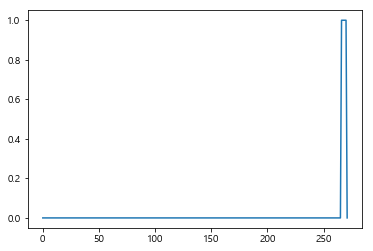

In [140]:
adj_result['삼성생명']['Cond1_1_50'].plot()

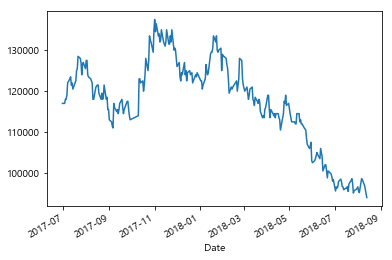

In [141]:
raw_data['삼성생명'].Close.loc['2017-06-30':].plot()

In [277]:
# trans1
stock_returns1 = {}
print('Transaction 1')
for stock, d_dict in adj_result.items():
    start = time.time()
    mid_check = {}
    for cond_name, pred in d_dict.items():
        n = int(max_precision_day[stock])
        try:
            res, number = transaction(stock, pred, n, 5, 5)
        except IndexError:
            continue
        res = (res.fillna(0)+1).cumprod()
        mid_check[cond_name] = (res.iloc[-1], res, number)
    stock_returns1[stock] = mid_check
    print(stock, ': {:.2f} sec'.format(time.time() - start))

# trans2
stock_returns2 = {}
print('\nTransaction 2')
for stock, d_dict in adj_result.items():
    start = time.time()
    mid_check = {}
    for cond_name, pred in d_dict.items():
        n = int(max_precision_day[stock])
        try:
            res, number = transaction(stock, pred, n, 1, 5)
        except IndexError:
            continue
        res = (res.fillna(0)+1).cumprod()
        mid_check[cond_name] = (res.iloc[-1], res, number)
    stock_returns2[stock] = mid_check
    print(stock, ': {:.2f} sec'.format(time.time() - start))

# trans3
stock_returns3 = {}
print('\nTransaction 3')
for stock, d_dict in adj_result.items():
    start = time.time()
    mid_check = {}
    for cond_name, pred in d_dict.items():
        n = int(max_precision_day[stock])
        try:
            res, number = transaction(stock, pred, n, n, n)
        except IndexError:
            continue
        res = (res.fillna(0)+1).cumprod()
        mid_check[cond_name] = (res.iloc[-1], res, number)
    stock_returns3[stock] = mid_check
    print(stock, ': {:.2f} sec'.format(time.time() - start))
    
# trans4
stock_returns4 = {}
print('\nTransaction 4')
for stock, d_dict in adj_result.items():
    start = time.time()
    mid_check = {}
    for cond_name, pred in d_dict.items():
        n = int(max_precision_day[stock])
        try:
            res, number = transaction(stock, pred, n, 1, n)
        except IndexError:
            continue
        res = (res.fillna(0)+1).cumprod()
        mid_check[cond_name] = (res.iloc[-1], res, number)
    stock_returns4[stock] = mid_check
    print(stock, ': {:.2f} sec'.format(time.time() - start))

Transaction 1
KB금융 : 29.35 sec
LG : 30.92 sec
LG생활건강 : 29.35 sec
LG화학 : 40.41 sec
NAVER : 41.93 sec
SK : 27.43 sec
SK이노베이션 : 30.66 sec
SK텔레콤 : 31.98 sec
SK하이닉스 : 39.30 sec
삼성생명 : 29.91 sec
삼성전자 : 41.65 sec
삼성중공업 : 39.97 sec
셀트리온 : 37.29 sec
신한지주 : 35.51 sec
현대건설 : 43.21 sec
현대글로비스 : 36.67 sec

Transaction 2
KB금융 : 4.64 sec
LG : 7.44 sec
LG생활건강 : 4.75 sec
LG화학 : 13.18 sec
NAVER : 12.89 sec
SK : 4.78 sec
SK이노베이션 : 7.05 sec
SK텔레콤 : 7.84 sec
SK하이닉스 : 13.04 sec
삼성생명 : 6.99 sec
삼성전자 : 14.58 sec
삼성중공업 : 12.06 sec
셀트리온 : 12.25 sec
신한지주 : 8.53 sec
현대건설 : 11.58 sec
현대글로비스 : 13.61 sec

Transaction 3
KB금융 : 28.11 sec
LG : 28.49 sec
LG생활건강 : 29.96 sec
LG화학 : 40.32 sec
NAVER : 37.86 sec
SK : 26.87 sec
SK이노베이션 : 32.68 sec
SK텔레콤 : 30.69 sec
SK하이닉스 : 39.73 sec
삼성생명 : 33.00 sec
삼성전자 : 41.27 sec
삼성중공업 : 40.24 sec
셀트리온 : 38.30 sec
신한지주 : 35.44 sec
현대건설 : 37.08 sec
현대글로비스 : 36.62 sec

Transaction 4
KB금융 : 6.47 sec
LG : 8.50 sec
LG생활건강 : 4.97 sec
LG화학 : 14.86 sec
NAVER : 15.06 sec
SK : 8.39 sec
SK이노베이션 : 13

In [278]:
return_close = {}
return_close['trans1'] = stock_returns1
return_close['trans2'] = stock_returns2
return_close['trans3'] = stock_returns3
return_close['trans4'] = stock_returns4

In [301]:
new_adj = {}
cond_li = adj_result['삼성전자'].keys()
for cond_name in cond_li:
    print(cond_name)
    p = pd.DataFrame()
    for stock, d_dict in adj_result.items():
        d = d_dict[cond_name]
        d.name = stock
        p = pd.concat((p, d), axis=1)
    new_adj[cond_name] = p

Cond1_1_30
Cond1_1_30+Cond1_1_40
Cond1_1_30+Cond1_1_50
Cond1_1_30+Cond1_1_60
Cond1_1_30+Cond1_1_70
Cond1_1_30+Cond1_1_80
Cond1_1_30+Cond1_1_90
Cond1_1_30+Cond1_max_30
Cond1_1_30+Cond1_max_40
Cond1_1_30+Cond1_max_50
Cond1_1_30+Cond1_max_60
Cond1_1_30+Cond1_max_70
Cond1_1_30+Cond1_max_80
Cond1_1_30+Cond1_max_90
Cond1_1_30+Cond2_1_30
Cond1_1_30+Cond2_1_40
Cond1_1_30+Cond2_1_50
Cond1_1_30+Cond2_1_60
Cond1_1_30+Cond2_1_70
Cond1_1_30+Cond2_1_80
Cond1_1_30+Cond2_1_90
Cond1_1_30+Cond2_max_30
Cond1_1_30+Cond2_max_40
Cond1_1_30+Cond2_max_50
Cond1_1_30+Cond2_max_60
Cond1_1_30+Cond2_max_70
Cond1_1_30+Cond2_max_80
Cond1_1_30+Cond2_max_90
Cond1_1_40+Cond1_1_30
Cond1_1_40
Cond1_1_40+Cond1_1_50
Cond1_1_40+Cond1_1_60
Cond1_1_40+Cond1_1_70
Cond1_1_40+Cond1_1_80
Cond1_1_40+Cond1_1_90
Cond1_1_40+Cond1_max_30
Cond1_1_40+Cond1_max_40
Cond1_1_40+Cond1_max_50
Cond1_1_40+Cond1_max_60
Cond1_1_40+Cond1_max_70
Cond1_1_40+Cond1_max_80
Cond1_1_40+Cond1_max_90
Cond1_1_40+Cond2_1_30
Cond1_1_40+Cond2_1_40
Cond1_1_40+C

Cond1_max_80+Cond2_1_40
Cond1_max_80+Cond2_1_50
Cond1_max_80+Cond2_1_60
Cond1_max_80+Cond2_1_70
Cond1_max_80+Cond2_1_80
Cond1_max_80+Cond2_1_90
Cond1_max_80+Cond2_max_30
Cond1_max_80+Cond2_max_40
Cond1_max_80+Cond2_max_50
Cond1_max_80+Cond2_max_60
Cond1_max_80+Cond2_max_70
Cond1_max_80+Cond2_max_80
Cond1_max_80+Cond2_max_90
Cond1_max_90+Cond1_1_30
Cond1_max_90+Cond1_1_40
Cond1_max_90+Cond1_1_50
Cond1_max_90+Cond1_1_60
Cond1_max_90+Cond1_1_70
Cond1_max_90+Cond1_1_80
Cond1_max_90+Cond1_1_90
Cond1_max_90+Cond1_max_30
Cond1_max_90+Cond1_max_40
Cond1_max_90+Cond1_max_50
Cond1_max_90+Cond1_max_60
Cond1_max_90+Cond1_max_70
Cond1_max_90+Cond1_max_80
Cond1_max_90
Cond1_max_90+Cond2_1_30
Cond1_max_90+Cond2_1_40
Cond1_max_90+Cond2_1_50
Cond1_max_90+Cond2_1_60
Cond1_max_90+Cond2_1_70
Cond1_max_90+Cond2_1_80
Cond1_max_90+Cond2_1_90
Cond1_max_90+Cond2_max_30
Cond1_max_90+Cond2_max_40
Cond1_max_90+Cond2_max_50
Cond1_max_90+Cond2_max_60
Cond1_max_90+Cond2_max_70
Cond1_max_90+Cond2_max_80
Cond1_max_90+

Cond2_max_70+Cond1_1_50
Cond2_max_70+Cond1_1_60
Cond2_max_70+Cond1_1_70
Cond2_max_70+Cond1_1_80
Cond2_max_70+Cond1_1_90
Cond2_max_70+Cond1_max_30
Cond2_max_70+Cond1_max_40
Cond2_max_70+Cond1_max_50
Cond2_max_70+Cond1_max_60
Cond2_max_70+Cond1_max_70
Cond2_max_70+Cond1_max_80
Cond2_max_70+Cond1_max_90
Cond2_max_70+Cond2_1_30
Cond2_max_70+Cond2_1_40
Cond2_max_70+Cond2_1_50
Cond2_max_70+Cond2_1_60
Cond2_max_70+Cond2_1_70
Cond2_max_70+Cond2_1_80
Cond2_max_70+Cond2_1_90
Cond2_max_70+Cond2_max_30
Cond2_max_70+Cond2_max_40
Cond2_max_70+Cond2_max_50
Cond2_max_70+Cond2_max_60
Cond2_max_70
Cond2_max_70+Cond2_max_80
Cond2_max_70+Cond2_max_90
Cond2_max_80+Cond1_1_30
Cond2_max_80+Cond1_1_40
Cond2_max_80+Cond1_1_50
Cond2_max_80+Cond1_1_60
Cond2_max_80+Cond1_1_70
Cond2_max_80+Cond1_1_80
Cond2_max_80+Cond1_1_90
Cond2_max_80+Cond1_max_30
Cond2_max_80+Cond1_max_40
Cond2_max_80+Cond1_max_50
Cond2_max_80+Cond1_max_60
Cond2_max_80+Cond1_max_70
Cond2_max_80+Cond1_max_80
Cond2_max_80+Cond1_max_90
Cond2_max_8

In [302]:
new_adj['Cond1_1_30']

,KB금융,LG,LG생활건강,LG화학,NAVER,SK,SK이노베이션,SK텔레콤,SK하이닉스,삼성생명,삼성전자,삼성중공업,셀트리온,신한지주,현대건설,현대글로비스
0,1,0,0,1,0,1,1,1,1,1,1,0,1,1,0,1
1,1,0,0,1,0,1,1,1,1,1,1,0,1,1,0,1
2,1,0,0,1,0,1,1,1,1,1,1,0,1,1,0,1
3,1,0,0,1,0,1,1,1,1,0,1,0,1,1,0,1
4,1,0,0,1,0,1,1,1,1,1,1,0,1,1,0,1
5,1,0,0,1,0,1,0,1,1,1,1,0,1,1,0,1
6,1,0,0,1,0,1,0,1,1,1,1,0,1,1,0,1
7,1,0,0,1,0,1,0,1,1,1,1,0,1,1,0,1
8,1,0,0,1,0,1,1,1,1,1,1,0,1,1,0,1
9,1,0,0,1,0,0,0,1,1,1,1,0,1,1,0,1


In [290]:
close_table = pd.DataFrame()
for stock, df in raw_data.items():
    d = df['Close']
    d.name = stock
    close_table = pd.concat((close_table, d), axis=1)
close_table = close_table.loc['2017-06-30':]

In [314]:
buy_li = new_adj['Cond1_1_30'].rolling(7).mean().iloc[6].map(step_fn)

In [321]:
buy_li

KB금융       1
LG         0
LG생활건강     0
LG화학       1
NAVER      0
SK         1
SK이노베이션    1
SK텔레콤      1
SK하이닉스     1
삼성생명       1
삼성전자       1
삼성중공업      0
셀트리온       1
신한지주       1
현대건설       0
현대글로비스     1
Name: 6, dtype: int64

In [340]:
idx = 6
initial_money = 10000000
assign = initial_money / sum(buy_li)
a = (assign / (close_table.iloc[idx] * buy_li)).replace(np.inf, 0).map(int)
close_table * a

,KB금융,LG,LG생활건강,LG화학,NAVER,SK,SK이노베이션,SK텔레콤,SK하이닉스,삼성생명,삼성전자,삼성중공업,셀트리온,신한지주,현대건설,현대글로비스
Date,,,,,,,,,,,,,,,,
2017-06-30,865500.0,0.0,0.0,873000.0,0.0,834000.0,792500.0,798000.0,876200.0,819000.0,855720.0,0.0,8.850480e+05,887400.0,0.0,942000.0
2017-07-03,867000.0,0.0,0.0,889500.0,0.0,846000.0,805000.0,823500.0,861900.0,819000.0,849960.0,0.0,8.881200e+05,891900.0,0.0,948000.0
2017-07-04,867000.0,0.0,0.0,870000.0,0.0,829500.0,800000.0,792000.0,855400.0,826000.0,846000.0,0.0,8.681280e+05,898200.0,0.0,942000.0
2017-07-05,859500.0,0.0,0.0,873000.0,0.0,832500.0,800000.0,802500.0,884000.0,826000.0,856440.0,0.0,8.512080e+05,891900.0,0.0,930000.0
2017-07-06,871500.0,0.0,0.0,870000.0,0.0,829500.0,792500.0,772500.0,885300.0,833000.0,865080.0,0.0,8.735120e+05,885600.0,0.0,924000.0
2017-07-07,850500.0,0.0,0.0,867000.0,0.0,807000.0,797500.0,769500.0,865800.0,854000.0,861480.0,0.0,8.765840e+05,880200.0,0.0,918000.0
2017-07-10,861000.0,0.0,0.0,874500.0,0.0,813000.0,800000.0,766500.0,874900.0,861000.0,875880.0,0.0,8.688960e+05,889200.0,0.0,906000.0
2017-07-11,855000.0,0.0,0.0,897000.0,0.0,807000.0,827500.0,780000.0,897000.0,864500.0,882000.0,0.0,8.650480e+05,899100.0,0.0,906000.0
2017-07-12,858000.0,0.0,0.0,898500.0,0.0,802500.0,817500.0,771000.0,895700.0,850500.0,897840.0,0.0,8.319840e+05,892800.0,0.0,906000.0


In [344]:
buy_li[buy_li==1].index

Index(['KB금융', 'LG화학', 'SK', 'SK이노베이션', 'SK텔레콤', 'SK하이닉스', '삼성생명', '삼성전자',
       '셀트리온', '신한지주', '현대글로비스'],
      dtype='object')

In [345]:
res = pd.Series(index=close_table.index)
res.iloc[0] = initial_money

In [355]:
np.isnan(res.iloc[2])

True

In [449]:
price_table = close_table
pred_table = new_adj['Cond1_1_30']
judge_period=5
hold_period=5
initial_money = 10000000
res = pd.Series(index=price_table.index)
res.iloc[0] = initial_money
stamp_arr = pd.Series(np.zeros(len(price_table.columns)), index=price_table.columns)

In [452]:
idx = 30
if idx < 30: 
    res.iloc[idx+1] = res.iloc[idx]
    a = 0
else:
    buy_li = pred_table.rolling(judge_period).mean().iloc[idx].map(step_fn)
    for stock in price_table.columns:
        if (stamp_arr[stock] == 0) & (buy_li[stock] == 1):
            stamp_arr[stock] += hold_period
        if (stamp_arr[stock] > 0) & (buy_li[stock] == 0):
            buy_li[stock] = 1
    assign = res.iloc[idx] / sum(buy_li)
    hold_num_stock = (assign / (price_table.iloc[idx+1] * buy_li)).replace(np.inf, 0).map(int)
    now_price = price_table * buy_li
    a = 1
if a > 0:
    if (sum(buy_li) == 0) & (np.isnan(res.iloc[idx+1])):
        res.iloc[idx+1] = res.iloc[idx]
    else:
        daily_profit = sum(now_price.iloc[idx+2] - now_price.iloc[idx+1])
        res.iloc[idx+2] = res.iloc[idx+1] + daily_profit
        for stock in buy_li.index:
            stamp_arr[stock] -= 1
            stamp_arr = pd.Series(np.where(stamp_arr<0, 0, stamp_arr).astype(int), index=price_table.columns)

In [457]:
res.iloc[29:35]

Date
2017-08-10    10000000.0
2017-08-11    10000000.0
2017-08-14           NaN
2017-08-16           NaN
2017-08-17           NaN
2017-08-18           NaN
dtype: float64

In [460]:
def portfolio_transaction(price_table, pred_table, max_precision_day,
                         judge_period=1, hold_period=5):
    """
    Daily Evaluation
    """
    initial_money = 10000000
    res = pd.Series(index=price_table.index)
    res.iloc[0] = initial_money
    stamp_arr = pd.Series(np.zeros(len(price_table.columns)), index=price_table.columns)
    for idx in range(270):
        if idx < 30: 
            res.iloc[idx+1] = res.iloc[idx]
            res.iloc[idx+2] = res.iloc[idx]
            continue
        else:
            buy_li = pred_table.rolling(judge_period).mean().iloc[idx].map(step_fn)
            for stock in price_table.columns:
                if (stamp_arr[stock] == 0) & (buy_li[stock] == 1):
                    stamp_arr[stock] += hold_period
                if (stamp_arr[stock] > 0) & (buy_li[stock] == 0):
                    buy_li[stock] = 1
            assign = res.iloc[idx] / sum(buy_li)
            hold_num_stock = (assign / (price_table.iloc[idx+1] * buy_li)).replace(np.inf, 0).map(int)
            now_price = price_table * buy_li
        if (sum(buy_li) == 0) & (np.isnan(res.iloc[idx+1])):
            res.iloc[idx+1] = res.iloc[idx]
        else:
            daily_profit = sum(now_price.iloc[idx+2] - now_price.iloc[idx+1])
            res.iloc[idx+2] = res.iloc[idx+1] + daily_profit
            for stock in buy_li.index:
                stamp_arr[stock] -= 1
                stamp_arr = pd.Series(np.where(stamp_arr<0, 0, stamp_arr).astype(int), 
                                      index=price_table.columns)
    return res
    
def transaction(stock, pred, n, 
                judge_period=1, hold_period=5):
    res = pd.Series(index=range(272))
    close = raw_data[stock]['Close'].loc['2017-06-30':]
    number, stamp = 0, 0
    for idx in range(260):
        if judge_period > 1:
            buy_condition = \
            (np.mean(pred.iloc[idx-judge_period+1:idx+1]) >= .5)
        else:
            buy_condition = (pred.iloc[idx] == 1)
        if idx < n: continue
        if (buy_condition) | (stamp > 0):
            res.iloc[idx+2] = np.log(
                close.iloc[idx+2] / close.iloc[idx+1])
            if stamp == 0:
                stamp = hold_period
                number += 1
            else:
                stamp -= 1
    return res, number

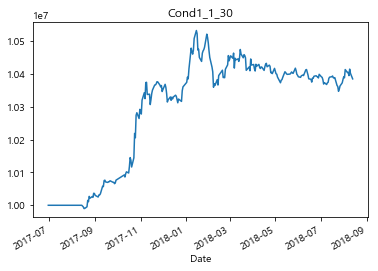

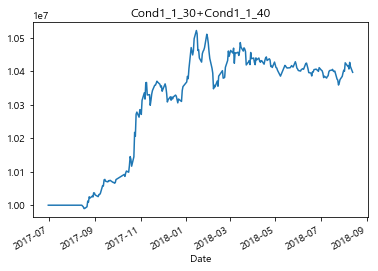

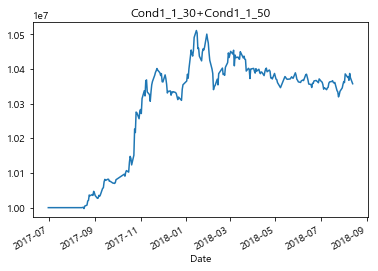

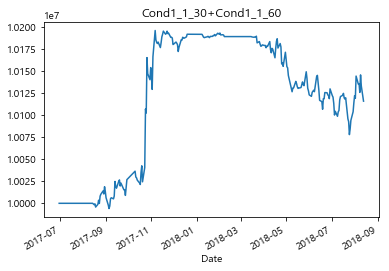

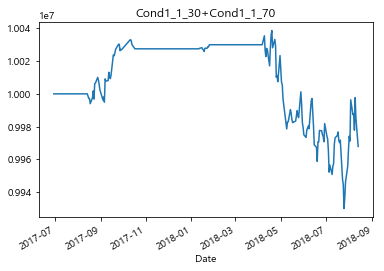

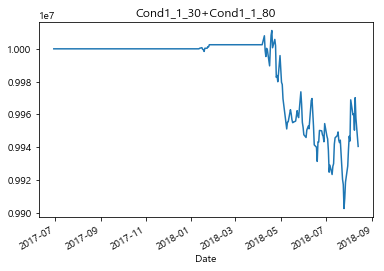

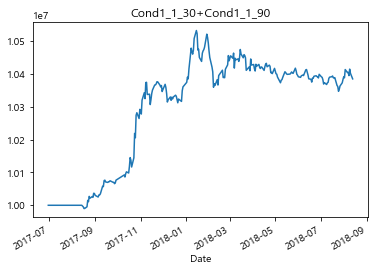

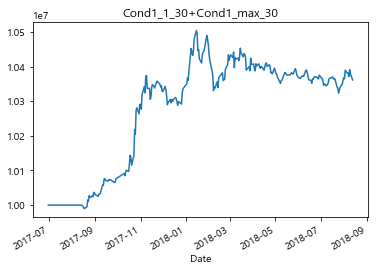

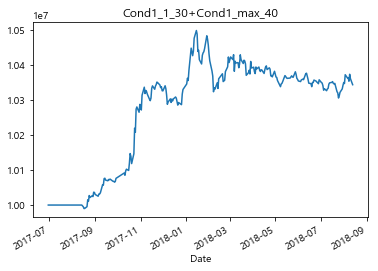

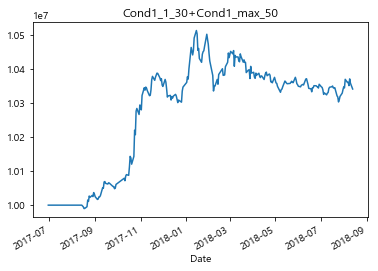

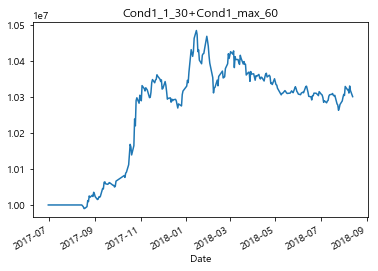

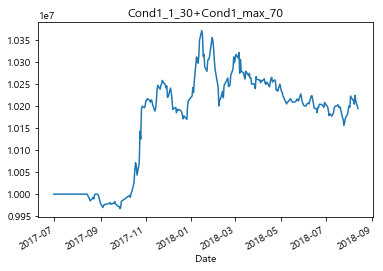

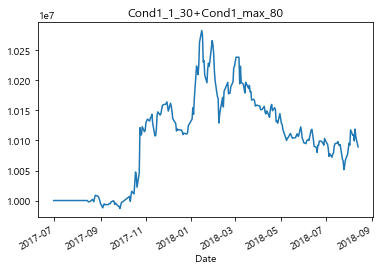

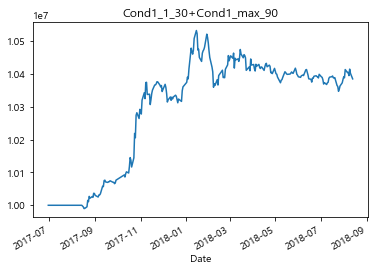

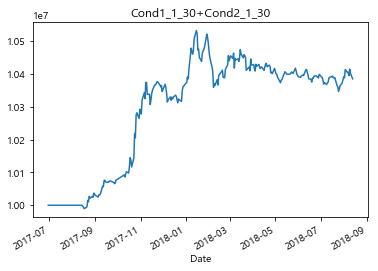

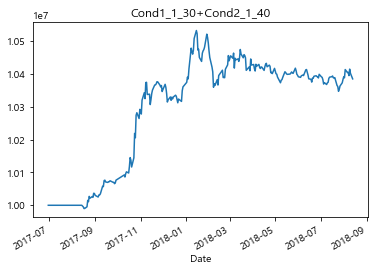

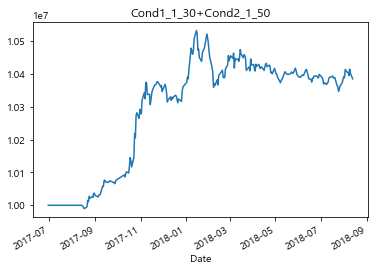

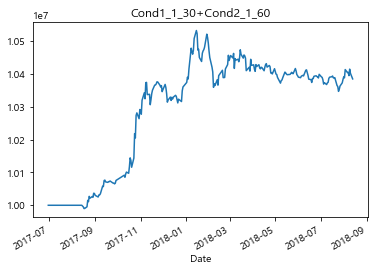

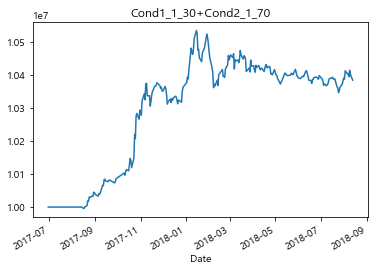

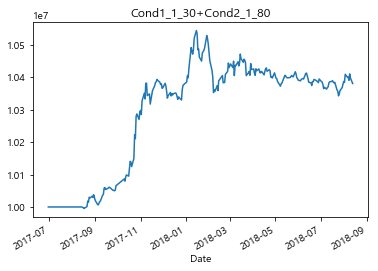

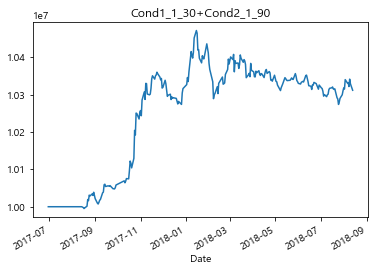

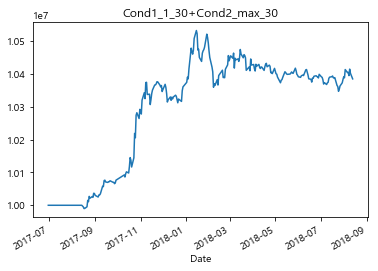

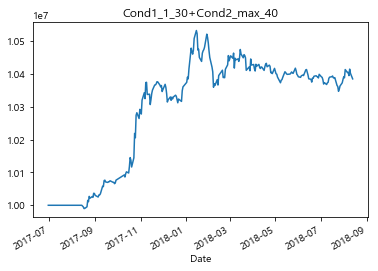

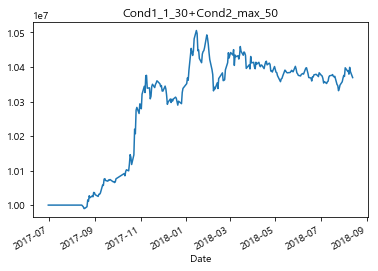

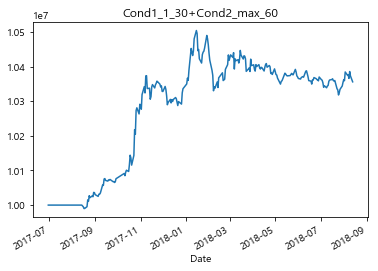

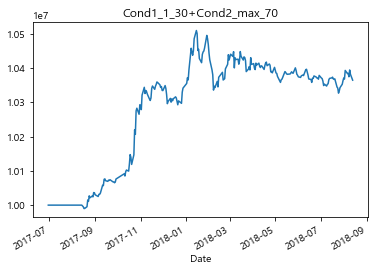

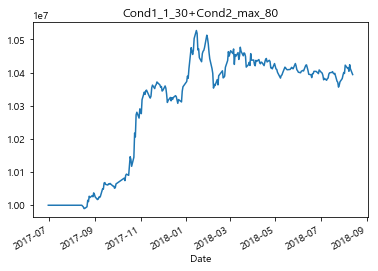

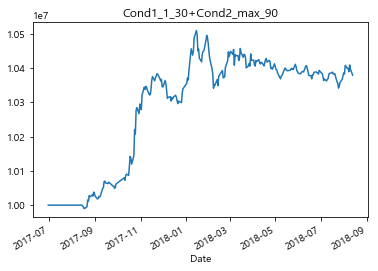

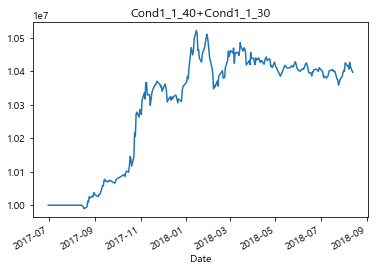

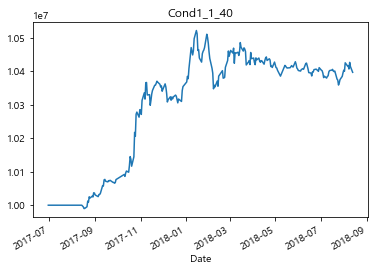

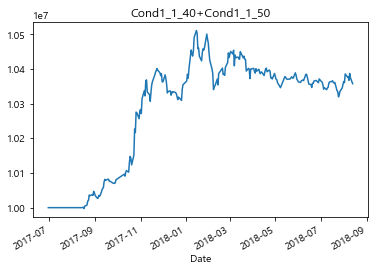

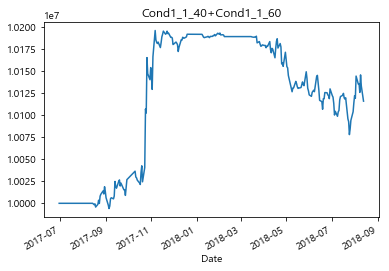

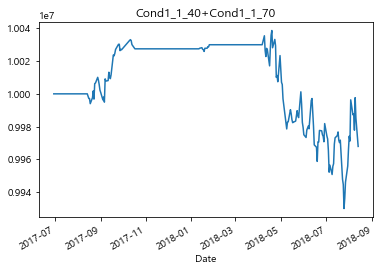

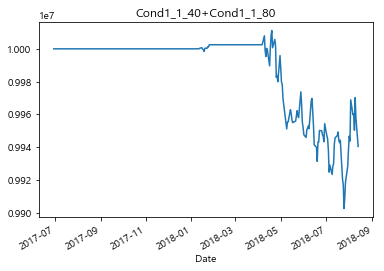

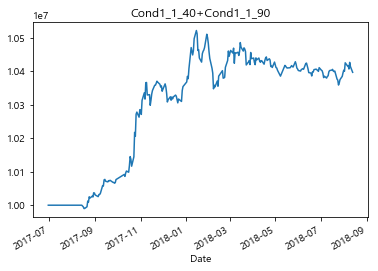

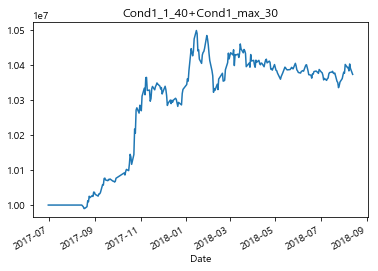

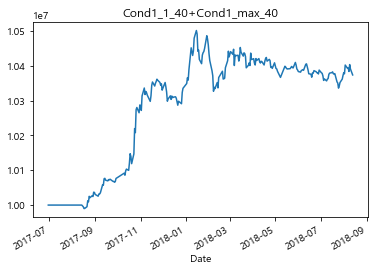

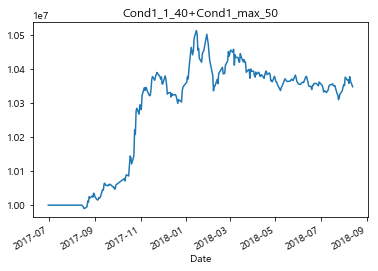

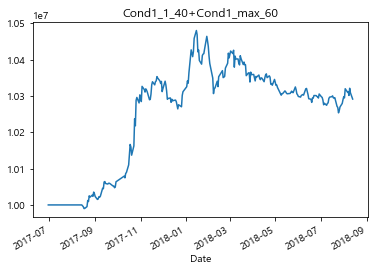

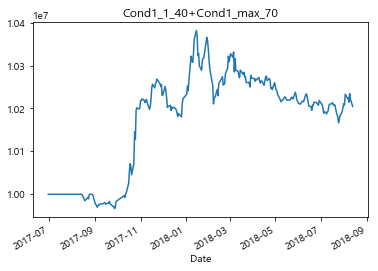

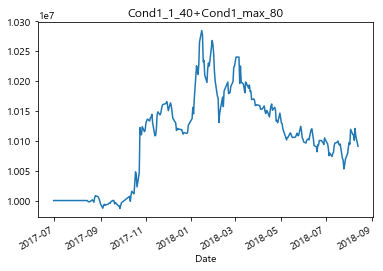

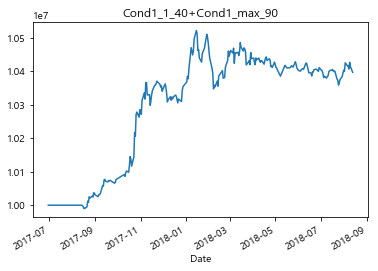

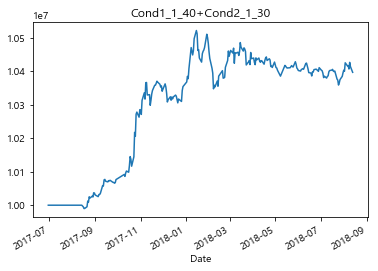

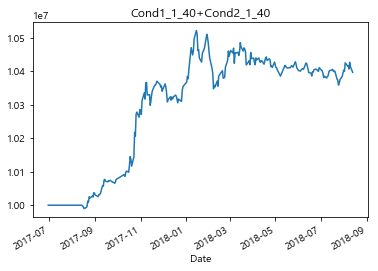

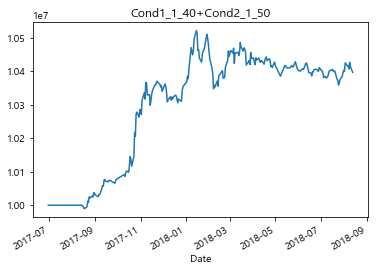

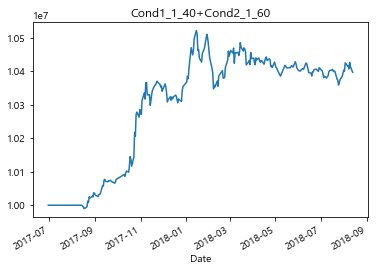

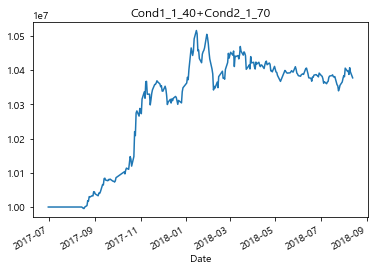

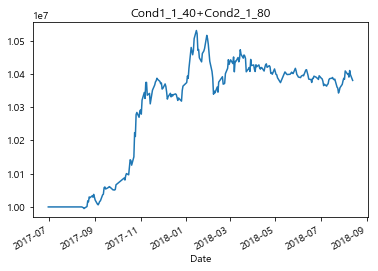

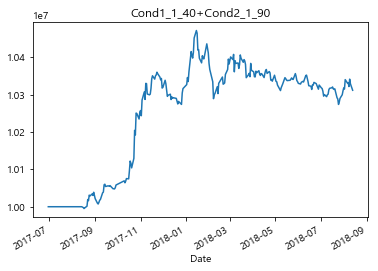

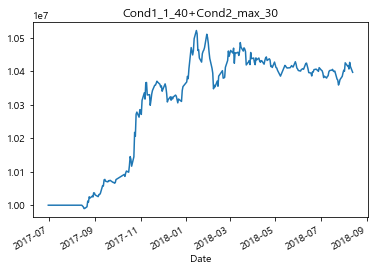

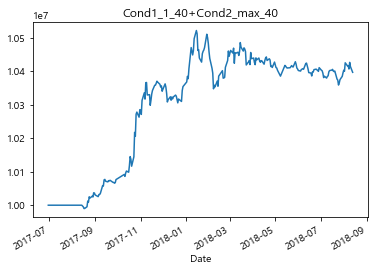

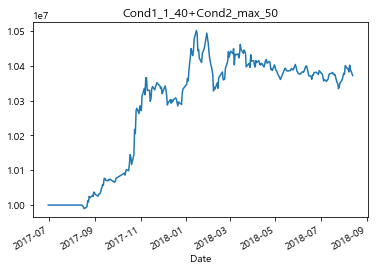

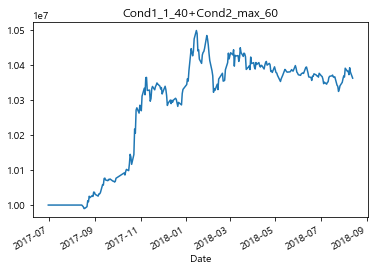

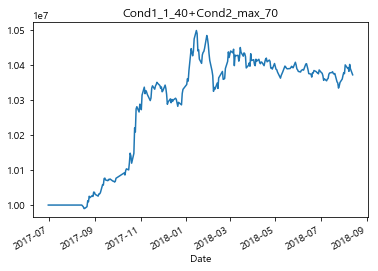

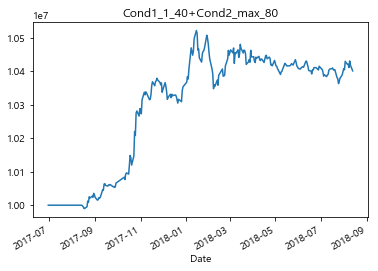

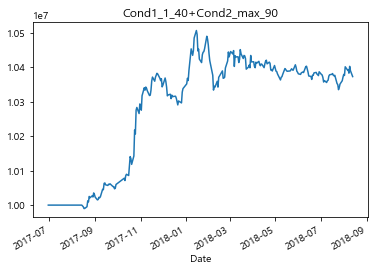

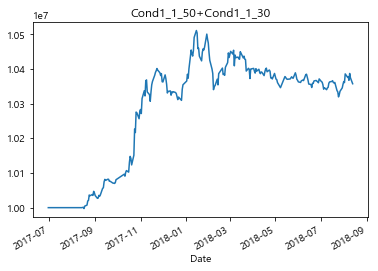

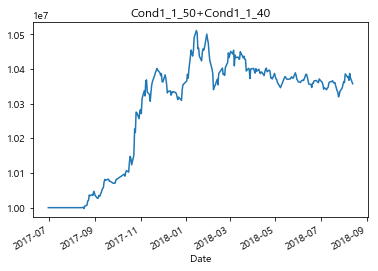

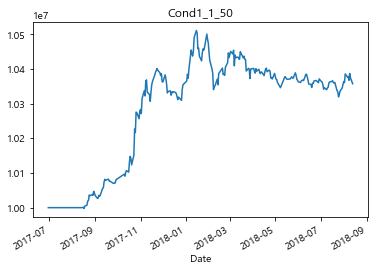

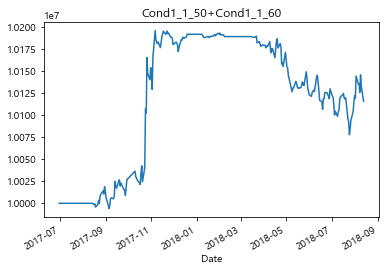

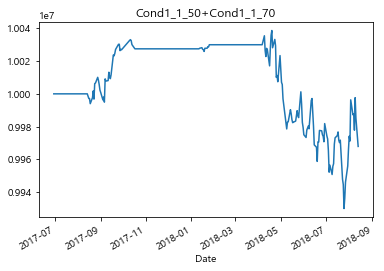

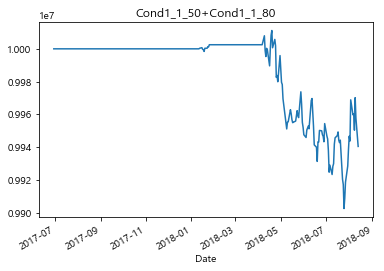

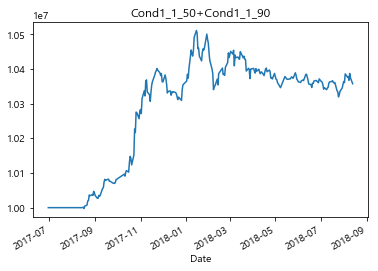

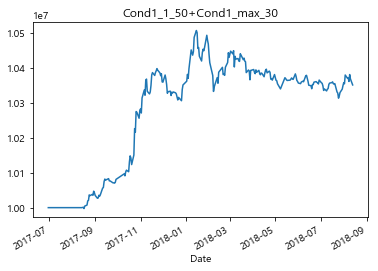

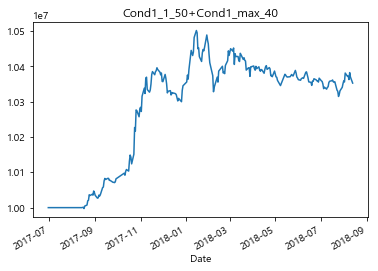

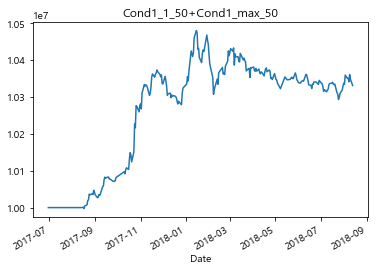

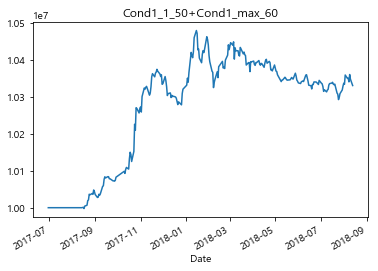

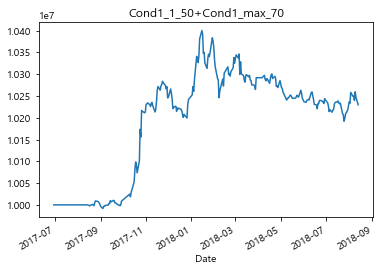

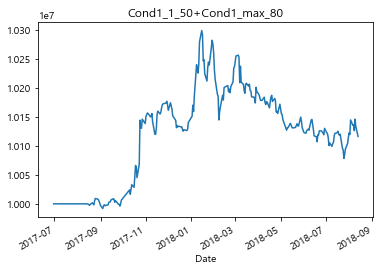

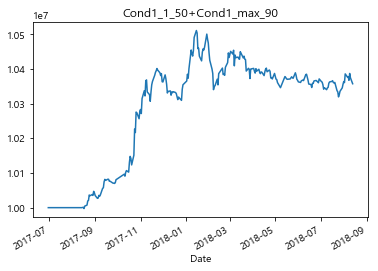

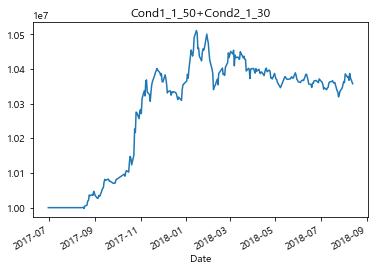

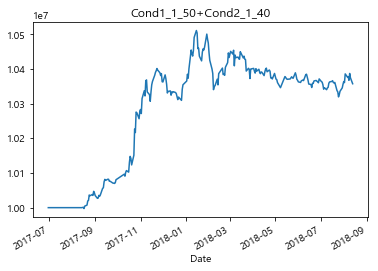

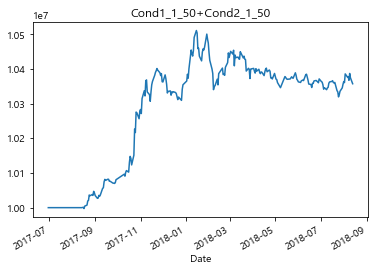

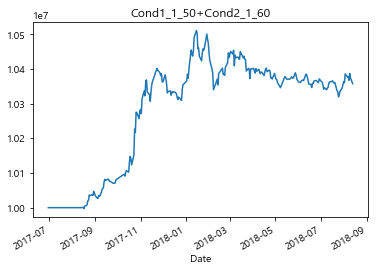

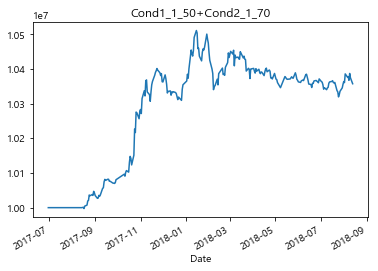

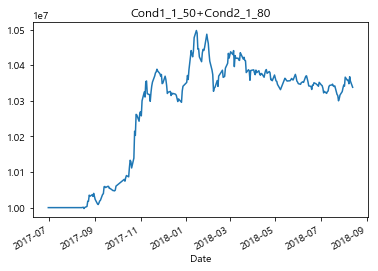

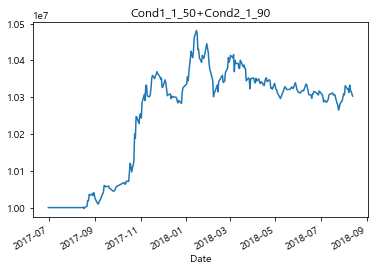

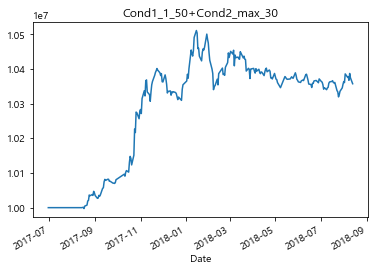

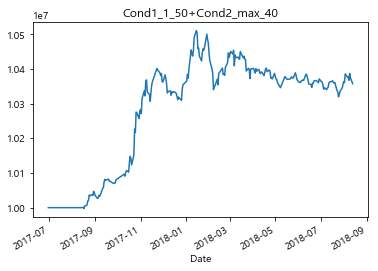

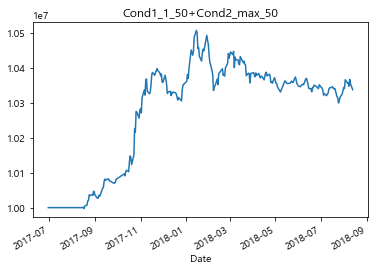

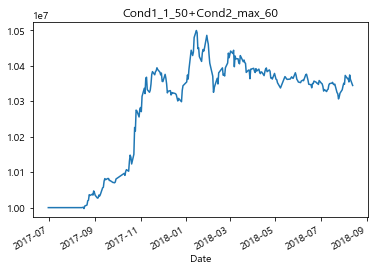

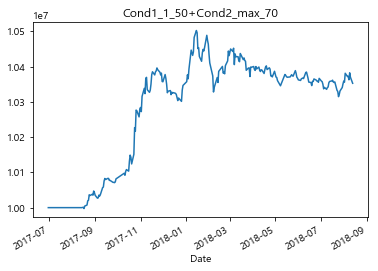

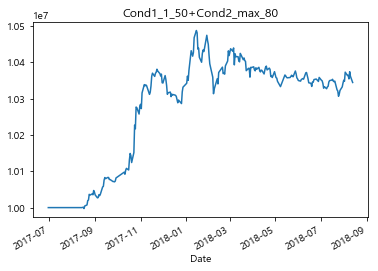

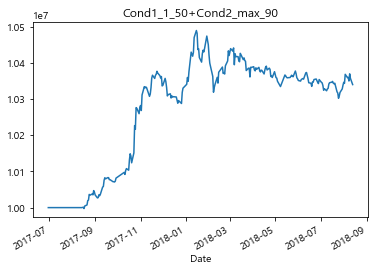

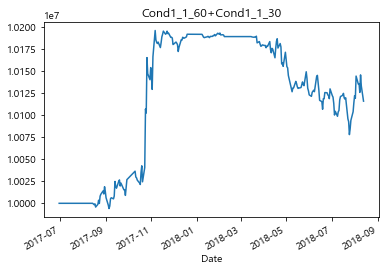

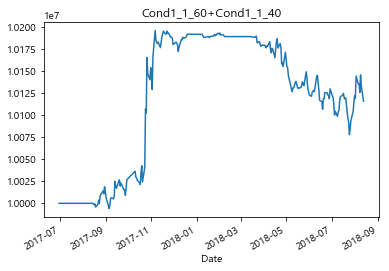

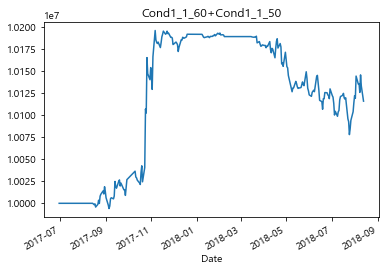

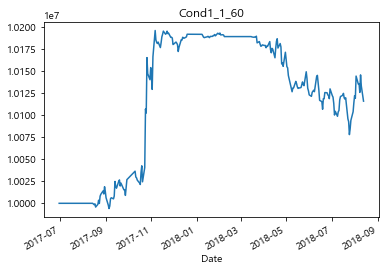

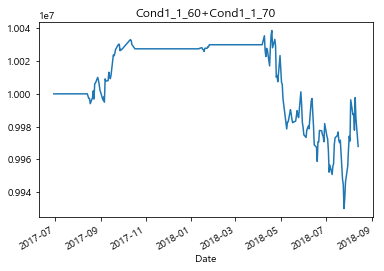

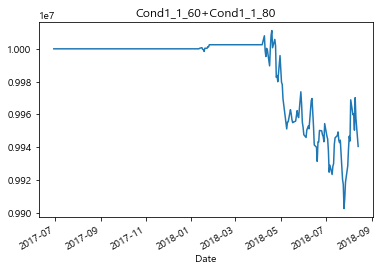

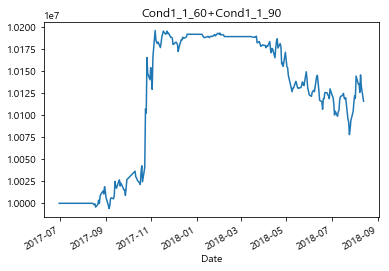

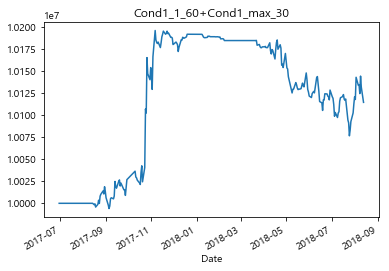

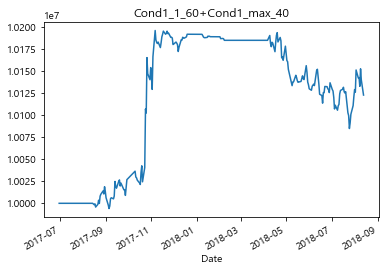

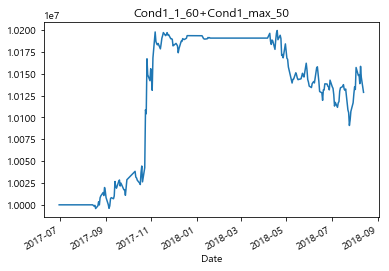

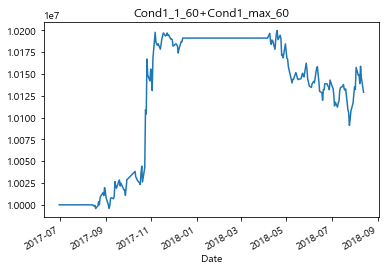

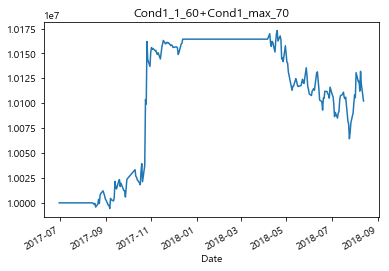

KeyboardInterrupt: 

In [490]:
for cond_name in new_adj.keys():
    res = portfolio_transaction(close_table, new_adj[cond_name], max_precision_day,
                     judge_period=5, hold_period=5)
    res.plot()
    plt.title(cond_name)
    plt.show()

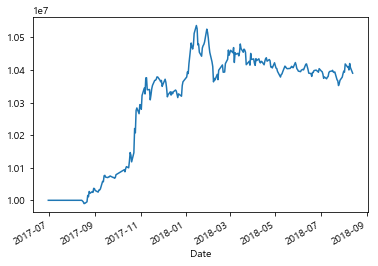

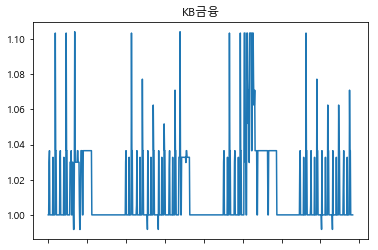

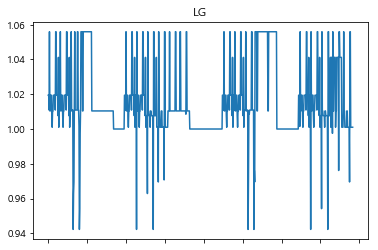

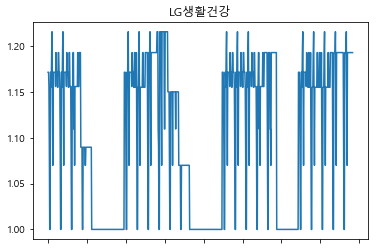

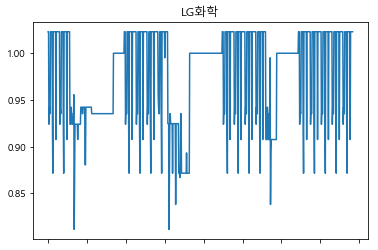

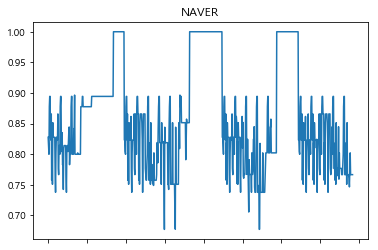

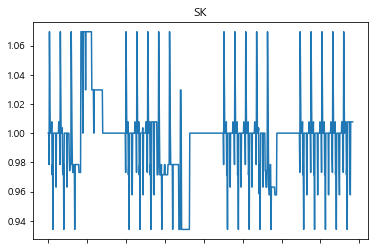

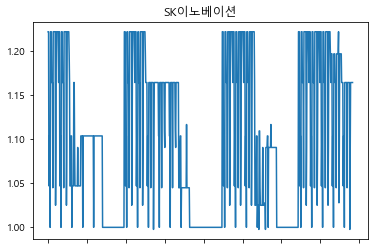

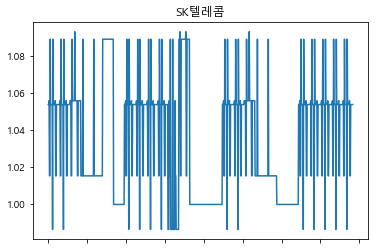

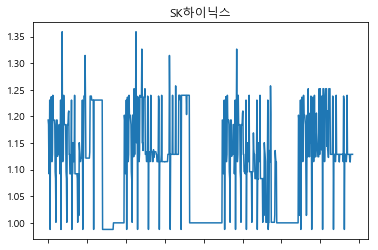

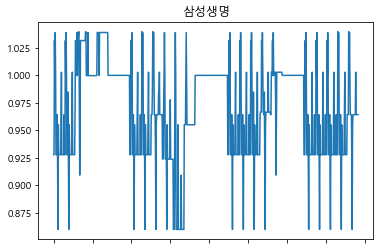

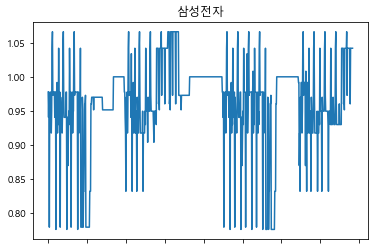

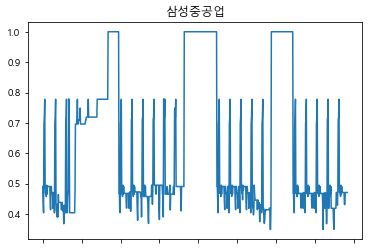

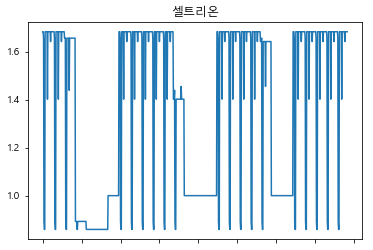

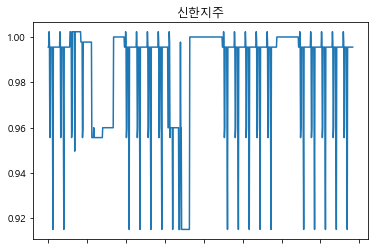

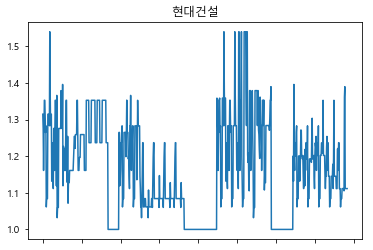

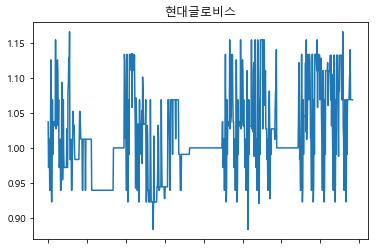

In [279]:
for stock in adj_result.keys():
    pd.Series({i:j[0] for i,j in return_close['trans1'][stock].items()}).plot()
    plt.title(stock)
    plt.show()

In [57]:
for name, (returns, ser, num) in return_close['trans1']['KB금융'].items():
    print(name)

Cond1_1_30
Cond1_1_30+Cond1_1_40
Cond1_1_30+Cond1_1_50
Cond1_1_30+Cond1_1_60
Cond1_1_30+Cond1_1_70
Cond1_1_30+Cond1_1_80
Cond1_1_30+Cond1_1_90
Cond1_1_30+Cond1_max_30
Cond1_1_30+Cond1_max_40
Cond1_1_30+Cond1_max_50
Cond1_1_30+Cond1_max_60
Cond1_1_30+Cond1_max_70
Cond1_1_30+Cond1_max_80
Cond1_1_30+Cond1_max_90
Cond1_1_30+Cond2_1_30
Cond1_1_30+Cond2_1_40
Cond1_1_30+Cond2_1_50
Cond1_1_30+Cond2_1_60
Cond1_1_30+Cond2_1_70
Cond1_1_30+Cond2_1_80
Cond1_1_30+Cond2_1_90
Cond1_1_30+Cond2_max_30
Cond1_1_30+Cond2_max_40
Cond1_1_30+Cond2_max_50
Cond1_1_30+Cond2_max_60
Cond1_1_30+Cond2_max_70
Cond1_1_30+Cond2_max_80
Cond1_1_30+Cond2_max_90
Cond1_1_40+Cond1_1_30
Cond1_1_40
Cond1_1_40+Cond1_1_50
Cond1_1_40+Cond1_1_60
Cond1_1_40+Cond1_1_70
Cond1_1_40+Cond1_1_80
Cond1_1_40+Cond1_1_90
Cond1_1_40+Cond1_max_30
Cond1_1_40+Cond1_max_40
Cond1_1_40+Cond1_max_50
Cond1_1_40+Cond1_max_60
Cond1_1_40+Cond1_max_70
Cond1_1_40+Cond1_max_80
Cond1_1_40+Cond1_max_90
Cond1_1_40+Cond2_1_30
Cond1_1_40+Cond2_1_40
Cond1_1_40+C